In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'retinamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 1080
Validation samples: 120
Test samples: 400


In [7]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 1080
    Root location: /home/oussama/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 120
    Root location: /home/oussama/.medmnist
    Split: val
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0'

In [8]:
# visualization

train_dataset.montage(length=1)

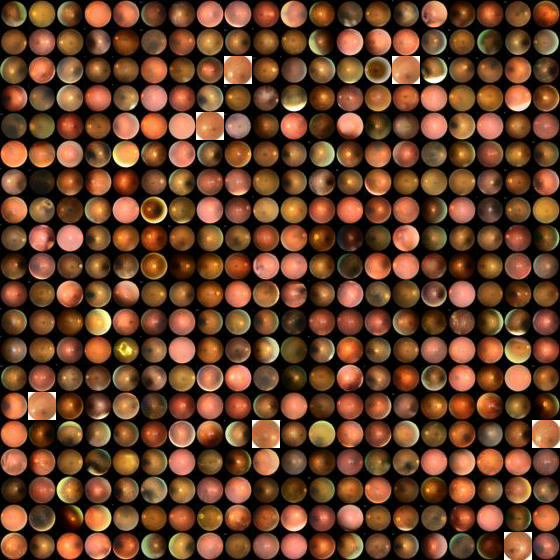

In [9]:
# montage

train_dataset.montage(length=20)

In [10]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [11]:
class M5(torch.nn.Module):
    def __init__(self, output=9):
        super(M5, self).__init__()
        # Layer 1
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.ReLU1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 2
        self.Conv2 = torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.ReLU2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 3
        self.Conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.ReLU3 = nn.ReLU()
        self.AvgPool3 = torch.nn.AvgPool2d(kernel_size = 3)
        self.Flatten = nn.ReLU()
        self.FC1 = torch.nn.Linear(1*1*128, output)


    def forward(self, x):
        out = self.Conv1(x)
        out = self.ReLU1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.ReLU2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.ReLU3(out)
        out = self.AvgPool3(out)
        out = self.Flatten(out)
        out = out.view(out.shape[0], -1)  # Fix flattening
        out = self.FC1(out)
        return out
    
model = M5(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [12]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)
    

In [13]:
class M4(torch.nn.Module):
    def __init__(self, hidden=84, output=10):
        super(M4, self).__init__()
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.Square1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        self.Conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.Square2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        self.Conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1, padding=0)
        self.Square3 = nn.ReLU()
        self.Flatten = Flatten()
        self.FC1 = torch.nn.Linear(120, hidden)
        self.Square4 = nn.ReLU()
        self.FC2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        out = self.Conv1(x)
        out = self.Square1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.Square2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.Square3(out)
        out = self.Flatten(out)
        out = self.FC1(out)
        out = self.Square4(out)
        out = self.FC2(out)
        return out
    
model = M4(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [17]:
class M8(nn.Module):
    def __init__(self, outputs=2):
        super(M8, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size=2)  # ADDED: Extra pooling layer

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=400, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = M8(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [20]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [22]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 9/9 [00:00<00:00, 10.70it/s]



Summary: Train Loss: 1.6122, Train Acc: 17.04%, Validation Loss: 0.8028, Validation Acc: 25.83%

Epoch [2/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.29it/s]



Summary: Train Loss: 1.6005, Train Acc: 21.67%, Validation Loss: 0.7953, Validation Acc: 40.00%

Epoch [3/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.58it/s]



Summary: Train Loss: 1.5850, Train Acc: 41.30%, Validation Loss: 0.7867, Validation Acc: 45.00%

Epoch [4/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.13it/s]



Summary: Train Loss: 1.5656, Train Acc: 45.00%, Validation Loss: 0.7784, Validation Acc: 45.00%

Epoch [5/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.71it/s]



Summary: Train Loss: 1.5525, Train Acc: 45.00%, Validation Loss: 0.7699, Validation Acc: 45.00%

Epoch [6/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]



Summary: Train Loss: 1.5324, Train Acc: 45.00%, Validation Loss: 0.7618, Validation Acc: 45.00%

Epoch [7/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.90it/s]



Summary: Train Loss: 1.5163, Train Acc: 45.00%, Validation Loss: 0.7536, Validation Acc: 45.00%

Epoch [8/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.78it/s]



Summary: Train Loss: 1.4979, Train Acc: 45.00%, Validation Loss: 0.7454, Validation Acc: 45.00%

Epoch [9/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.15it/s]



Summary: Train Loss: 1.4852, Train Acc: 45.00%, Validation Loss: 0.7370, Validation Acc: 45.00%

Epoch [10/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.45it/s]



Summary: Train Loss: 1.4646, Train Acc: 45.00%, Validation Loss: 0.7286, Validation Acc: 45.00%

Epoch [11/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]



Summary: Train Loss: 1.4522, Train Acc: 45.00%, Validation Loss: 0.7200, Validation Acc: 45.00%

Epoch [12/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.67it/s]



Summary: Train Loss: 1.4417, Train Acc: 45.00%, Validation Loss: 0.7113, Validation Acc: 45.00%

Epoch [13/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.62it/s]



Summary: Train Loss: 1.4240, Train Acc: 45.00%, Validation Loss: 0.7032, Validation Acc: 45.00%

Epoch [14/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.54it/s]



Summary: Train Loss: 1.4075, Train Acc: 45.00%, Validation Loss: 0.6953, Validation Acc: 45.00%

Epoch [15/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.02it/s]



Summary: Train Loss: 1.3943, Train Acc: 45.00%, Validation Loss: 0.6879, Validation Acc: 45.00%

Epoch [16/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]



Summary: Train Loss: 1.3812, Train Acc: 45.00%, Validation Loss: 0.6809, Validation Acc: 45.00%

Epoch [17/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.17it/s]



Summary: Train Loss: 1.3846, Train Acc: 45.00%, Validation Loss: 0.6751, Validation Acc: 45.00%

Epoch [18/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.61it/s]



Summary: Train Loss: 1.3691, Train Acc: 45.00%, Validation Loss: 0.6707, Validation Acc: 45.00%

Epoch [19/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.39it/s]



Summary: Train Loss: 1.3540, Train Acc: 45.00%, Validation Loss: 0.6671, Validation Acc: 45.00%

Epoch [20/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.14it/s]



Summary: Train Loss: 1.3459, Train Acc: 45.00%, Validation Loss: 0.6635, Validation Acc: 45.00%

Epoch [21/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.05it/s]



Summary: Train Loss: 1.3431, Train Acc: 45.00%, Validation Loss: 0.6606, Validation Acc: 45.00%

Epoch [22/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.27it/s]



Summary: Train Loss: 1.3418, Train Acc: 45.00%, Validation Loss: 0.6579, Validation Acc: 45.00%

Epoch [23/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.24it/s]



Summary: Train Loss: 1.3285, Train Acc: 45.00%, Validation Loss: 0.6557, Validation Acc: 45.00%

Epoch [24/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.05it/s]



Summary: Train Loss: 1.3406, Train Acc: 45.00%, Validation Loss: 0.6534, Validation Acc: 45.00%

Epoch [25/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.62it/s]



Summary: Train Loss: 1.3520, Train Acc: 45.00%, Validation Loss: 0.6516, Validation Acc: 45.00%

Epoch [26/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.79it/s]



Summary: Train Loss: 1.3269, Train Acc: 45.00%, Validation Loss: 0.6503, Validation Acc: 45.00%

Epoch [27/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.90it/s]



Summary: Train Loss: 1.3359, Train Acc: 45.00%, Validation Loss: 0.6486, Validation Acc: 45.00%

Epoch [28/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.08it/s]



Summary: Train Loss: 1.3362, Train Acc: 45.00%, Validation Loss: 0.6470, Validation Acc: 45.00%

Epoch [29/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.86it/s]



Summary: Train Loss: 1.3220, Train Acc: 45.00%, Validation Loss: 0.6457, Validation Acc: 45.00%

Epoch [30/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.03it/s]



Summary: Train Loss: 1.3280, Train Acc: 45.00%, Validation Loss: 0.6439, Validation Acc: 45.00%

Epoch [31/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.41it/s]



Summary: Train Loss: 1.3225, Train Acc: 45.00%, Validation Loss: 0.6427, Validation Acc: 45.00%

Epoch [32/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.43it/s]



Summary: Train Loss: 1.3223, Train Acc: 45.00%, Validation Loss: 0.6413, Validation Acc: 45.00%

Epoch [33/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.58it/s]



Summary: Train Loss: 1.3200, Train Acc: 45.00%, Validation Loss: 0.6396, Validation Acc: 45.00%

Epoch [34/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.72it/s]



Summary: Train Loss: 1.3178, Train Acc: 45.00%, Validation Loss: 0.6386, Validation Acc: 45.00%

Epoch [35/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.69it/s]



Summary: Train Loss: 1.3194, Train Acc: 45.00%, Validation Loss: 0.6377, Validation Acc: 45.00%

Epoch [36/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.12it/s]



Summary: Train Loss: 1.2975, Train Acc: 45.00%, Validation Loss: 0.6361, Validation Acc: 45.00%

Epoch [37/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.26it/s]



Summary: Train Loss: 1.3120, Train Acc: 45.00%, Validation Loss: 0.6343, Validation Acc: 45.00%

Epoch [38/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.34it/s]



Summary: Train Loss: 1.3062, Train Acc: 45.00%, Validation Loss: 0.6333, Validation Acc: 45.00%

Epoch [39/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.92it/s]



Summary: Train Loss: 1.3129, Train Acc: 45.00%, Validation Loss: 0.6323, Validation Acc: 45.00%

Epoch [40/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.92it/s]



Summary: Train Loss: 1.3061, Train Acc: 45.00%, Validation Loss: 0.6313, Validation Acc: 45.00%

Epoch [41/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.38it/s]



Summary: Train Loss: 1.3063, Train Acc: 45.00%, Validation Loss: 0.6306, Validation Acc: 45.00%

Epoch [42/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.52it/s]



Summary: Train Loss: 1.3044, Train Acc: 45.00%, Validation Loss: 0.6296, Validation Acc: 45.00%

Epoch [43/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.51it/s]



Summary: Train Loss: 1.3038, Train Acc: 45.00%, Validation Loss: 0.6290, Validation Acc: 45.00%

Epoch [44/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.79it/s]



Summary: Train Loss: 1.3071, Train Acc: 45.00%, Validation Loss: 0.6283, Validation Acc: 45.00%

Epoch [45/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.56it/s]



Summary: Train Loss: 1.3064, Train Acc: 45.00%, Validation Loss: 0.6270, Validation Acc: 45.00%

Epoch [46/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.77it/s]



Summary: Train Loss: 1.2926, Train Acc: 45.00%, Validation Loss: 0.6252, Validation Acc: 45.00%

Epoch [47/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.99it/s]



Summary: Train Loss: 1.3059, Train Acc: 45.00%, Validation Loss: 0.6243, Validation Acc: 45.00%

Epoch [48/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.33it/s]



Summary: Train Loss: 1.3116, Train Acc: 45.00%, Validation Loss: 0.6239, Validation Acc: 45.00%

Epoch [49/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.23it/s]



Summary: Train Loss: 1.3070, Train Acc: 45.00%, Validation Loss: 0.6242, Validation Acc: 45.00%

Epoch [50/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.46it/s]



Summary: Train Loss: 1.2988, Train Acc: 45.00%, Validation Loss: 0.6244, Validation Acc: 45.00%

Epoch [51/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.79it/s]



Summary: Train Loss: 1.2972, Train Acc: 45.00%, Validation Loss: 0.6231, Validation Acc: 45.00%

Epoch [52/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]



Summary: Train Loss: 1.3033, Train Acc: 45.00%, Validation Loss: 0.6219, Validation Acc: 45.00%

Epoch [53/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.30it/s]



Summary: Train Loss: 1.3182, Train Acc: 45.00%, Validation Loss: 0.6207, Validation Acc: 45.00%

Epoch [54/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.77it/s]



Summary: Train Loss: 1.3063, Train Acc: 45.00%, Validation Loss: 0.6213, Validation Acc: 45.00%

Epoch [55/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.17it/s]



Summary: Train Loss: 1.2958, Train Acc: 45.00%, Validation Loss: 0.6213, Validation Acc: 45.00%

Epoch [56/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.09it/s]



Summary: Train Loss: 1.3024, Train Acc: 45.00%, Validation Loss: 0.6204, Validation Acc: 45.00%

Epoch [57/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.08it/s]



Summary: Train Loss: 1.2881, Train Acc: 45.00%, Validation Loss: 0.6196, Validation Acc: 45.00%

Epoch [58/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.06it/s]



Summary: Train Loss: 1.3032, Train Acc: 45.00%, Validation Loss: 0.6189, Validation Acc: 45.00%

Epoch [59/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.43it/s]



Summary: Train Loss: 1.2845, Train Acc: 45.00%, Validation Loss: 0.6178, Validation Acc: 45.00%

Epoch [60/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.61it/s]



Summary: Train Loss: 1.2969, Train Acc: 45.28%, Validation Loss: 0.6175, Validation Acc: 45.00%

Epoch [61/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]



Summary: Train Loss: 1.2792, Train Acc: 45.00%, Validation Loss: 0.6167, Validation Acc: 42.50%

Epoch [62/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.20it/s]



Summary: Train Loss: 1.2907, Train Acc: 45.37%, Validation Loss: 0.6162, Validation Acc: 41.67%

Epoch [63/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.89it/s]



Summary: Train Loss: 1.2761, Train Acc: 45.56%, Validation Loss: 0.6156, Validation Acc: 41.67%

Epoch [64/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.14it/s]



Summary: Train Loss: 1.3074, Train Acc: 45.74%, Validation Loss: 0.6153, Validation Acc: 40.83%

Epoch [65/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.62it/s]



Summary: Train Loss: 1.3069, Train Acc: 46.20%, Validation Loss: 0.6152, Validation Acc: 40.83%

Epoch [66/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.06it/s]



Summary: Train Loss: 1.2768, Train Acc: 46.02%, Validation Loss: 0.6148, Validation Acc: 41.67%

Epoch [67/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]



Summary: Train Loss: 1.2988, Train Acc: 46.39%, Validation Loss: 0.6143, Validation Acc: 41.67%

Epoch [68/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.79it/s]



Summary: Train Loss: 1.2946, Train Acc: 46.76%, Validation Loss: 0.6142, Validation Acc: 40.00%

Epoch [69/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.42it/s]



Summary: Train Loss: 1.2872, Train Acc: 45.83%, Validation Loss: 0.6134, Validation Acc: 40.00%

Epoch [70/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.19it/s]



Summary: Train Loss: 1.2890, Train Acc: 45.65%, Validation Loss: 0.6129, Validation Acc: 42.50%

Epoch [71/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.43it/s]



Summary: Train Loss: 1.2833, Train Acc: 46.02%, Validation Loss: 0.6126, Validation Acc: 41.67%

Epoch [72/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.21it/s]



Summary: Train Loss: 1.2996, Train Acc: 45.46%, Validation Loss: 0.6117, Validation Acc: 41.67%

Epoch [73/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]



Summary: Train Loss: 1.2828, Train Acc: 45.65%, Validation Loss: 0.6116, Validation Acc: 40.83%

Epoch [74/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.41it/s]



Summary: Train Loss: 1.2933, Train Acc: 46.02%, Validation Loss: 0.6104, Validation Acc: 41.67%

Epoch [75/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.49it/s]



Summary: Train Loss: 1.2865, Train Acc: 46.02%, Validation Loss: 0.6106, Validation Acc: 40.83%

Epoch [76/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.94it/s]



Summary: Train Loss: 1.2857, Train Acc: 46.30%, Validation Loss: 0.6113, Validation Acc: 41.67%

Epoch [77/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.07it/s]



Summary: Train Loss: 1.2811, Train Acc: 46.02%, Validation Loss: 0.6117, Validation Acc: 43.33%

Epoch [78/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.61it/s]



Summary: Train Loss: 1.2765, Train Acc: 47.59%, Validation Loss: 0.6110, Validation Acc: 43.33%

Epoch [79/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.78it/s]



Summary: Train Loss: 1.2999, Train Acc: 47.87%, Validation Loss: 0.6100, Validation Acc: 43.33%

Epoch [80/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.18it/s]



Summary: Train Loss: 1.2812, Train Acc: 47.22%, Validation Loss: 0.6101, Validation Acc: 43.33%

Epoch [81/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.24it/s]



Summary: Train Loss: 1.2990, Train Acc: 46.85%, Validation Loss: 0.6107, Validation Acc: 44.17%

Epoch [82/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.63it/s]



Summary: Train Loss: 1.2648, Train Acc: 46.11%, Validation Loss: 0.6107, Validation Acc: 45.83%

Epoch [83/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.15it/s]



Summary: Train Loss: 1.2982, Train Acc: 45.83%, Validation Loss: 0.6095, Validation Acc: 45.00%

Epoch [84/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.53it/s]



Summary: Train Loss: 1.2928, Train Acc: 47.13%, Validation Loss: 0.6105, Validation Acc: 45.83%

Epoch [85/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.75it/s]



Summary: Train Loss: 1.2845, Train Acc: 45.83%, Validation Loss: 0.6110, Validation Acc: 46.67%

Epoch [86/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.05it/s]



Summary: Train Loss: 1.2813, Train Acc: 47.87%, Validation Loss: 0.6096, Validation Acc: 45.83%

Epoch [87/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.51it/s]



Summary: Train Loss: 1.2787, Train Acc: 46.20%, Validation Loss: 0.6093, Validation Acc: 45.83%

Epoch [88/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.49it/s]



Summary: Train Loss: 1.2932, Train Acc: 46.39%, Validation Loss: 0.6092, Validation Acc: 45.83%

Epoch [89/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.73it/s]



Summary: Train Loss: 1.2901, Train Acc: 45.37%, Validation Loss: 0.6092, Validation Acc: 45.83%

Epoch [90/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.40it/s]



Summary: Train Loss: 1.2822, Train Acc: 45.83%, Validation Loss: 0.6084, Validation Acc: 45.83%

Epoch [91/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.74it/s]



Summary: Train Loss: 1.2867, Train Acc: 45.65%, Validation Loss: 0.6086, Validation Acc: 46.67%

Epoch [92/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.69it/s]



Summary: Train Loss: 1.2790, Train Acc: 46.85%, Validation Loss: 0.6085, Validation Acc: 47.50%

Epoch [93/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.33it/s]



Summary: Train Loss: 1.2844, Train Acc: 46.48%, Validation Loss: 0.6082, Validation Acc: 47.50%

Epoch [94/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.17it/s]



Summary: Train Loss: 1.2665, Train Acc: 46.20%, Validation Loss: 0.6079, Validation Acc: 47.50%

Epoch [95/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.29it/s]



Summary: Train Loss: 1.2739, Train Acc: 46.76%, Validation Loss: 0.6065, Validation Acc: 47.50%

Epoch [96/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]



Summary: Train Loss: 1.2900, Train Acc: 46.20%, Validation Loss: 0.6071, Validation Acc: 47.50%

Epoch [97/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.52it/s]



Summary: Train Loss: 1.2905, Train Acc: 45.65%, Validation Loss: 0.6074, Validation Acc: 47.50%

Epoch [98/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]



Summary: Train Loss: 1.2800, Train Acc: 46.11%, Validation Loss: 0.6079, Validation Acc: 46.67%

Epoch [99/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.47it/s]



Summary: Train Loss: 1.2887, Train Acc: 46.48%, Validation Loss: 0.6076, Validation Acc: 46.67%

Epoch [100/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.39it/s]


Summary: Train Loss: 1.2800, Train Acc: 46.11%, Validation Loss: 0.6074, Validation Acc: 46.67%


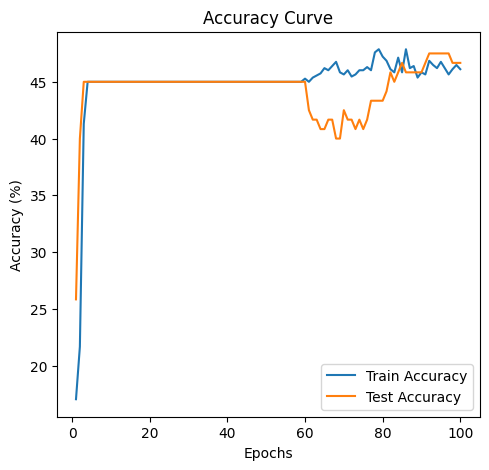

In [23]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [24]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 1.3006, Accuracy: 48.75%


In [ ]:
# Save the trained model
MODEL_PATH = "d../models/retina_model_without_res.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")

Model saved successfully as dermato_model.pth!


In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.relu1 = ApproxReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )

        self.relu2 = ApproxReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out

In [26]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # Normalize activations
        self.relu1 = ApproxReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [27]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [28]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]



Summary: Train Loss: 1.5791, Train Acc: 22.50%, Validation Loss: 0.7615, Validation Acc: 45.00%

Epoch [2/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.48it/s]



Summary: Train Loss: 1.4655, Train Acc: 45.00%, Validation Loss: 0.7209, Validation Acc: 45.00%

Epoch [3/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.69it/s]



Summary: Train Loss: 1.4013, Train Acc: 45.00%, Validation Loss: 0.6934, Validation Acc: 45.00%

Epoch [4/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.82it/s]



Summary: Train Loss: 1.3802, Train Acc: 45.00%, Validation Loss: 0.6769, Validation Acc: 45.00%

Epoch [5/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.38it/s]



Summary: Train Loss: 1.3651, Train Acc: 45.00%, Validation Loss: 0.6641, Validation Acc: 45.00%

Epoch [6/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.86it/s]



Summary: Train Loss: 1.3518, Train Acc: 45.00%, Validation Loss: 0.6551, Validation Acc: 45.00%

Epoch [7/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.83it/s]



Summary: Train Loss: 1.3388, Train Acc: 45.00%, Validation Loss: 0.6475, Validation Acc: 45.00%

Epoch [8/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]



Summary: Train Loss: 1.3251, Train Acc: 45.28%, Validation Loss: 0.6415, Validation Acc: 46.67%

Epoch [9/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.53it/s]



Summary: Train Loss: 1.3172, Train Acc: 44.81%, Validation Loss: 0.6352, Validation Acc: 45.00%

Epoch [10/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.65it/s]



Summary: Train Loss: 1.3180, Train Acc: 44.72%, Validation Loss: 0.6299, Validation Acc: 44.17%

Epoch [11/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.86it/s]



Summary: Train Loss: 1.3083, Train Acc: 45.28%, Validation Loss: 0.6264, Validation Acc: 45.00%

Epoch [12/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.42it/s]



Summary: Train Loss: 1.3281, Train Acc: 45.09%, Validation Loss: 0.6222, Validation Acc: 45.83%

Epoch [13/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.14it/s]



Summary: Train Loss: 1.3030, Train Acc: 44.72%, Validation Loss: 0.6205, Validation Acc: 44.17%

Epoch [14/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.10it/s]



Summary: Train Loss: 1.2938, Train Acc: 45.65%, Validation Loss: 0.6186, Validation Acc: 44.17%

Epoch [15/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.49it/s]



Summary: Train Loss: 1.2824, Train Acc: 45.19%, Validation Loss: 0.6152, Validation Acc: 44.17%

Epoch [16/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.92it/s]



Summary: Train Loss: 1.2881, Train Acc: 46.02%, Validation Loss: 0.6131, Validation Acc: 44.17%

Epoch [17/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.10it/s]



Summary: Train Loss: 1.2915, Train Acc: 46.02%, Validation Loss: 0.6113, Validation Acc: 43.33%

Epoch [18/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.23it/s]



Summary: Train Loss: 1.2954, Train Acc: 45.65%, Validation Loss: 0.6101, Validation Acc: 45.00%

Epoch [19/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.22it/s]



Summary: Train Loss: 1.2822, Train Acc: 47.50%, Validation Loss: 0.6104, Validation Acc: 45.00%

Epoch [20/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.90it/s]



Summary: Train Loss: 1.2871, Train Acc: 45.09%, Validation Loss: 0.6089, Validation Acc: 44.17%

Epoch [21/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.96it/s]



Summary: Train Loss: 1.2908, Train Acc: 45.56%, Validation Loss: 0.6052, Validation Acc: 43.33%

Epoch [22/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.02it/s]



Summary: Train Loss: 1.2720, Train Acc: 46.85%, Validation Loss: 0.6043, Validation Acc: 43.33%

Epoch [23/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.53it/s]



Summary: Train Loss: 1.3084, Train Acc: 45.65%, Validation Loss: 0.6045, Validation Acc: 43.33%

Epoch [24/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.01it/s]



Summary: Train Loss: 1.3025, Train Acc: 47.04%, Validation Loss: 0.6051, Validation Acc: 44.17%

Epoch [25/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.11it/s]



Summary: Train Loss: 1.2886, Train Acc: 46.20%, Validation Loss: 0.6056, Validation Acc: 43.33%

Epoch [26/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.70it/s]



Summary: Train Loss: 1.2877, Train Acc: 45.83%, Validation Loss: 0.6041, Validation Acc: 45.83%

Epoch [27/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.87it/s]



Summary: Train Loss: 1.2785, Train Acc: 47.22%, Validation Loss: 0.6037, Validation Acc: 44.17%

Epoch [28/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.26it/s]



Summary: Train Loss: 1.2894, Train Acc: 46.39%, Validation Loss: 0.6015, Validation Acc: 44.17%

Epoch [29/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.51it/s]



Summary: Train Loss: 1.2821, Train Acc: 46.11%, Validation Loss: 0.6020, Validation Acc: 41.67%

Epoch [30/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.44it/s]



Summary: Train Loss: 1.2817, Train Acc: 47.78%, Validation Loss: 0.6012, Validation Acc: 41.67%

Epoch [31/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.33it/s]



Summary: Train Loss: 1.2749, Train Acc: 47.96%, Validation Loss: 0.6012, Validation Acc: 40.83%

Epoch [32/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]



Summary: Train Loss: 1.2752, Train Acc: 46.57%, Validation Loss: 0.6000, Validation Acc: 41.67%

Epoch [33/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.36it/s]



Summary: Train Loss: 1.2775, Train Acc: 47.69%, Validation Loss: 0.6014, Validation Acc: 45.00%

Epoch [34/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.85it/s]



Summary: Train Loss: 1.2648, Train Acc: 46.85%, Validation Loss: 0.5988, Validation Acc: 44.17%

Epoch [35/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.97it/s]



Summary: Train Loss: 1.2752, Train Acc: 46.20%, Validation Loss: 0.5974, Validation Acc: 42.50%

Epoch [36/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.13it/s]



Summary: Train Loss: 1.2815, Train Acc: 47.04%, Validation Loss: 0.5994, Validation Acc: 45.83%

Epoch [37/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]



Summary: Train Loss: 1.2703, Train Acc: 47.13%, Validation Loss: 0.5997, Validation Acc: 44.17%

Epoch [38/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.17it/s]



Summary: Train Loss: 1.2837, Train Acc: 47.50%, Validation Loss: 0.5977, Validation Acc: 42.50%

Epoch [39/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.64it/s]



Summary: Train Loss: 1.2740, Train Acc: 48.70%, Validation Loss: 0.5953, Validation Acc: 44.17%

Epoch [40/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.09it/s]



Summary: Train Loss: 1.2636, Train Acc: 46.48%, Validation Loss: 0.5942, Validation Acc: 43.33%

Epoch [41/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.23it/s]



Summary: Train Loss: 1.2690, Train Acc: 47.41%, Validation Loss: 0.5956, Validation Acc: 44.17%

Epoch [42/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.51it/s]



Summary: Train Loss: 1.2699, Train Acc: 46.94%, Validation Loss: 0.5941, Validation Acc: 43.33%

Epoch [43/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.07it/s]



Summary: Train Loss: 1.2739, Train Acc: 47.04%, Validation Loss: 0.5936, Validation Acc: 45.83%

Epoch [44/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.23it/s]



Summary: Train Loss: 1.2624, Train Acc: 46.94%, Validation Loss: 0.5931, Validation Acc: 45.83%

Epoch [45/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.93it/s]



Summary: Train Loss: 1.2846, Train Acc: 46.67%, Validation Loss: 0.5926, Validation Acc: 45.00%

Epoch [46/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.98it/s]



Summary: Train Loss: 1.2580, Train Acc: 48.52%, Validation Loss: 0.5929, Validation Acc: 45.83%

Epoch [47/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.97it/s]



Summary: Train Loss: 1.2753, Train Acc: 48.33%, Validation Loss: 0.5914, Validation Acc: 46.67%

Epoch [48/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.16it/s]



Summary: Train Loss: 1.2749, Train Acc: 47.59%, Validation Loss: 0.5952, Validation Acc: 50.83%

Epoch [49/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.17it/s]



Summary: Train Loss: 1.2807, Train Acc: 45.56%, Validation Loss: 0.5965, Validation Acc: 50.00%

Epoch [50/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.98it/s]



Summary: Train Loss: 1.2683, Train Acc: 47.41%, Validation Loss: 0.5962, Validation Acc: 47.50%

Epoch [51/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]



Summary: Train Loss: 1.2628, Train Acc: 49.26%, Validation Loss: 0.5924, Validation Acc: 42.50%

Epoch [52/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.94it/s]



Summary: Train Loss: 1.2705, Train Acc: 47.22%, Validation Loss: 0.5916, Validation Acc: 43.33%

Epoch [53/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.78it/s]



Summary: Train Loss: 1.2602, Train Acc: 46.85%, Validation Loss: 0.5911, Validation Acc: 45.00%

Epoch [54/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.42it/s]



Summary: Train Loss: 1.2657, Train Acc: 47.04%, Validation Loss: 0.5862, Validation Acc: 43.33%

Epoch [55/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.91it/s]



Summary: Train Loss: 1.2722, Train Acc: 45.83%, Validation Loss: 0.5888, Validation Acc: 45.83%

Epoch [56/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.63it/s]



Summary: Train Loss: 1.2649, Train Acc: 47.31%, Validation Loss: 0.5889, Validation Acc: 49.17%

Epoch [57/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.91it/s]



Summary: Train Loss: 1.2861, Train Acc: 46.76%, Validation Loss: 0.5874, Validation Acc: 46.67%

Epoch [58/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.48it/s]



Summary: Train Loss: 1.2623, Train Acc: 48.61%, Validation Loss: 0.5888, Validation Acc: 48.33%

Epoch [59/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]



Summary: Train Loss: 1.2541, Train Acc: 49.81%, Validation Loss: 0.5911, Validation Acc: 49.17%

Epoch [60/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.97it/s]



Summary: Train Loss: 1.2612, Train Acc: 49.17%, Validation Loss: 0.5910, Validation Acc: 49.17%

Epoch [61/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.41it/s]



Summary: Train Loss: 1.2589, Train Acc: 46.76%, Validation Loss: 0.5893, Validation Acc: 46.67%

Epoch [62/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]



Summary: Train Loss: 1.2594, Train Acc: 47.59%, Validation Loss: 0.5857, Validation Acc: 45.83%

Epoch [63/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.96it/s]



Summary: Train Loss: 1.2691, Train Acc: 47.50%, Validation Loss: 0.5857, Validation Acc: 45.00%

Epoch [64/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.55it/s]



Summary: Train Loss: 1.2539, Train Acc: 48.43%, Validation Loss: 0.5898, Validation Acc: 49.17%

Epoch [65/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.81it/s]



Summary: Train Loss: 1.2479, Train Acc: 46.57%, Validation Loss: 0.5867, Validation Acc: 47.50%

Epoch [66/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.05it/s]



Summary: Train Loss: 1.2608, Train Acc: 47.78%, Validation Loss: 0.5831, Validation Acc: 45.83%

Epoch [67/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.52it/s]



Summary: Train Loss: 1.2551, Train Acc: 47.78%, Validation Loss: 0.5823, Validation Acc: 46.67%

Epoch [68/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.16it/s]



Summary: Train Loss: 1.2434, Train Acc: 47.31%, Validation Loss: 0.5858, Validation Acc: 50.00%

Epoch [69/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.40it/s]



Summary: Train Loss: 1.2526, Train Acc: 48.15%, Validation Loss: 0.5817, Validation Acc: 47.50%

Epoch [70/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.67it/s]



Summary: Train Loss: 1.2523, Train Acc: 48.33%, Validation Loss: 0.5830, Validation Acc: 45.83%

Epoch [71/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.00it/s]



Summary: Train Loss: 1.2483, Train Acc: 47.41%, Validation Loss: 0.5867, Validation Acc: 48.33%

Epoch [72/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.36it/s]



Summary: Train Loss: 1.2592, Train Acc: 47.96%, Validation Loss: 0.5854, Validation Acc: 51.67%

Epoch [73/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.44it/s]



Summary: Train Loss: 1.2531, Train Acc: 46.48%, Validation Loss: 0.5851, Validation Acc: 45.83%

Epoch [74/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.56it/s]



Summary: Train Loss: 1.2669, Train Acc: 47.78%, Validation Loss: 0.5834, Validation Acc: 45.83%

Epoch [75/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.74it/s]



Summary: Train Loss: 1.2607, Train Acc: 48.89%, Validation Loss: 0.5826, Validation Acc: 47.50%

Epoch [76/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.44it/s]



Summary: Train Loss: 1.2609, Train Acc: 48.70%, Validation Loss: 0.5816, Validation Acc: 45.00%

Epoch [77/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]



Summary: Train Loss: 1.2550, Train Acc: 47.04%, Validation Loss: 0.5795, Validation Acc: 45.00%

Epoch [78/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.62it/s]



Summary: Train Loss: 1.2525, Train Acc: 47.50%, Validation Loss: 0.5802, Validation Acc: 47.50%

Epoch [79/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.91it/s]



Summary: Train Loss: 1.2516, Train Acc: 48.06%, Validation Loss: 0.5847, Validation Acc: 50.83%

Epoch [80/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.22it/s]



Summary: Train Loss: 1.2422, Train Acc: 49.26%, Validation Loss: 0.5847, Validation Acc: 50.00%

Epoch [81/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.38it/s]



Summary: Train Loss: 1.2509, Train Acc: 49.54%, Validation Loss: 0.5825, Validation Acc: 50.00%

Epoch [82/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.44it/s]



Summary: Train Loss: 1.2458, Train Acc: 49.17%, Validation Loss: 0.5872, Validation Acc: 51.67%

Epoch [83/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.50it/s]



Summary: Train Loss: 1.2596, Train Acc: 48.98%, Validation Loss: 0.5810, Validation Acc: 49.17%

Epoch [84/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.30it/s]



Summary: Train Loss: 1.2488, Train Acc: 48.52%, Validation Loss: 0.5824, Validation Acc: 50.83%

Epoch [85/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.70it/s]



Summary: Train Loss: 1.2426, Train Acc: 48.70%, Validation Loss: 0.5816, Validation Acc: 45.00%

Epoch [86/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]



Summary: Train Loss: 1.2383, Train Acc: 47.59%, Validation Loss: 0.5781, Validation Acc: 48.33%

Epoch [87/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]



Summary: Train Loss: 1.2420, Train Acc: 48.61%, Validation Loss: 0.5855, Validation Acc: 50.00%

Epoch [88/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.37it/s]



Summary: Train Loss: 1.2501, Train Acc: 48.06%, Validation Loss: 0.5848, Validation Acc: 50.00%

Epoch [89/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.04it/s]



Summary: Train Loss: 1.2271, Train Acc: 48.89%, Validation Loss: 0.5808, Validation Acc: 44.17%

Epoch [90/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.23it/s]



Summary: Train Loss: 1.2455, Train Acc: 48.06%, Validation Loss: 0.5801, Validation Acc: 49.17%

Epoch [91/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.73it/s]



Summary: Train Loss: 1.2405, Train Acc: 48.61%, Validation Loss: 0.5794, Validation Acc: 48.33%

Epoch [92/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]



Summary: Train Loss: 1.2455, Train Acc: 48.24%, Validation Loss: 0.5879, Validation Acc: 50.00%

Epoch [93/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.38it/s]



Summary: Train Loss: 1.2357, Train Acc: 48.33%, Validation Loss: 0.5857, Validation Acc: 51.67%

Epoch [94/100] Training...


100%|██████████| 9/9 [00:00<00:00, 13.75it/s]



Summary: Train Loss: 1.2432, Train Acc: 47.41%, Validation Loss: 0.5844, Validation Acc: 50.83%

Epoch [95/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.64it/s]



Summary: Train Loss: 1.2458, Train Acc: 49.44%, Validation Loss: 0.5841, Validation Acc: 50.00%

Epoch [96/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.53it/s]



Summary: Train Loss: 1.2494, Train Acc: 47.59%, Validation Loss: 0.5831, Validation Acc: 50.83%

Epoch [97/100] Training...


100%|██████████| 9/9 [00:00<00:00, 15.01it/s]



Summary: Train Loss: 1.2523, Train Acc: 48.80%, Validation Loss: 0.5816, Validation Acc: 50.00%

Epoch [98/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]



Summary: Train Loss: 1.2494, Train Acc: 48.06%, Validation Loss: 0.5829, Validation Acc: 50.00%

Epoch [99/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.56it/s]



Summary: Train Loss: 1.2533, Train Acc: 48.52%, Validation Loss: 0.5832, Validation Acc: 50.00%

Epoch [100/100] Training...


100%|██████████| 9/9 [00:00<00:00, 14.94it/s]


Summary: Train Loss: 1.2232, Train Acc: 49.35%, Validation Loss: 0.5826, Validation Acc: 48.33%


In [29]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 1.2760, Accuracy: 51.00%


In [30]:
# Save the trained model
MODEL_PATH = "../models/retina_model.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")


Model saved successfully as ../models/retina_model.pth!
